## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

##  Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.17.0


## Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
!pip install datasets
import datasets

# This will load the emotion dataset from the Hugging Face Hub
dataset = datasets.load_dataset('emotion')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
# separate the train test and validtion dataset
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [10]:
# in the dataset the label is numbered from 0 to 5:
classes = set(dataset['train']['label'])
print(classes)

{0, 1, 2, 3, 4, 5}


0: sadness

1: joy

2: love

3: anger

4: fear

5: surprise

In [6]:
# defines a function that extracts the tweet and its label from the dataset
def get_tweet(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [7]:
tweets, labels = get_tweet(train)

{'text': 'i feel romantic too', 'label': 2}

In [8]:
tweets[0], labels[0]

('i didnt feel humiliated', 0)

# Tokenizer

This code initializes a tokenizer to convert text into sequences of numbers.

* `Tokenizer(num_words=10000, oov_token='<UNK>')` creates a tokenizer that keeps the 10000 most frequent words and replaces any words not in the vocabulary with `<UNK>`.
* `tokenizer.fit_on_texts(tweets)` updates internal vocabulary based on a list of texts.


In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

## Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

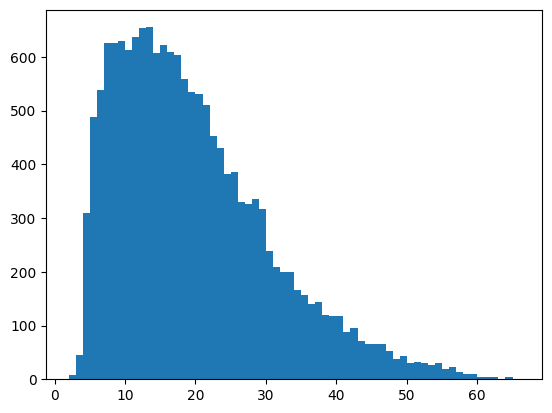

In [ ]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [12]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences


This function converts a list of tweets into sequences of numbers and pads them to ensure uniform length.

First, tokenizer.texts_to_sequences(tweets) transforms each tweet into a sequence of integers using the fitted tokenizer.

Then, pad_sequences pads or truncates sequences to a specified length (maxlen).

padding='post' adds padding after the sequence.
truncating='post' truncates sequences at the end.
Finally, the function returns the padded sequences.

In [13]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences,
                           maxlen=maxlen,
                           padding='post',
                           truncating='post')
    return padded

In [14]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [15]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [17]:
# dictionary that maps the labels to their emotion
label_dict = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

##  Creating the Model

1. Creating the model
2. Compiling the model

The model consists of the following layers:

Embedding: This layer maps each word to a 16-dimensional vector. It takes 10000 as the input dimension (vocabulary size) and maxlen as the length of input sequences.

Bidirectional LSTM: Two bidirectional LSTM layers with 20 units each. The first layer returns sequences, allowing information to flow to the next layer.

Dense: The output layer with 6 units (corresponding to the number of emotion classes) and softmax activation for multi-class classification.

The model is then compiled with the following:

Loss function: sparse_categorical_crossentropy is suitable for multi-class classification with integer labels.
Optimizer: adam is an adaptive optimization algorithm.
Metrics: accuracy is used to evaluate the model's performance.

In [44]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.build(input_shape=(None, maxlen))
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [45]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 50, 16)              │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 50, 40)              │           5,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 40)                  │           9,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             246 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 175,926 (687.21 KB)

 Trainable params: 175,926 (687.21 KB)

 Non-trainable params: 0 (0.00 B)

##  Training the Model

1. Preparing a validation set
2. Training the model

In [46]:
val_tweets, val_labels = get_tweet(val)
valid_sequences = get_sequences(tokenizer, val_tweets)

In [47]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

First, the training data (padded_train_seq and labels) and validation data (valid_sequences and val_labels) are reshaped to be compatible with the model's input shape. The reshaping adds an extra dimension to the data, likely to represent the number of channels (which is 1 in this case, as it's text data).

Then, the code calls the fit method on the model to train it using the training data and evaluate its performance on the validation data. The epochs parameter specifies the number of training iterations over the entire dataset. The callbacks parameter includes an EarlyStopping callback, which monitors the validation accuracy and stops the training process if the accuracy does not improve for two consecutive epochs (patience=2). This helps prevent overfitting and saves training time.

In [50]:
padded_train_seq = tf.convert_to_tensor(padded_train_seq)
labels = tf.convert_to_tensor(labels)
valid_sequences = tf.convert_to_tensor(valid_sequences)
val_labels = tf.convert_to_tensor(val_labels)

h = model.fit(padded_train_seq, labels,
              validation_data=(valid_sequences, val_labels),
              epochs=20,
              callbacks=[
                  tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
              ])

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8816 - loss: 0.3547 - val_accuracy: 0.8185 - val_loss: 0.5445
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9102 - loss: 0.2743 - val_accuracy: 0.8490 - val_loss: 0.4659
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9405 - loss: 0.1886 - val_accuracy: 0.8730 - val_loss: 0.3929
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9582 - loss: 0.1342 - val_accuracy: 0.8805 - val_loss: 0.3910
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9615 - loss: 0.1233 - val_accuracy: 0.8840 - val_loss: 0.3849
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9620 - loss: 0.1199 - val_accuracy: 0.8810 - val_loss: 0.3798
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9701 - loss: 0.0956 - val_accuracy: 0.8765 - val_loss: 0.3854


##  Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

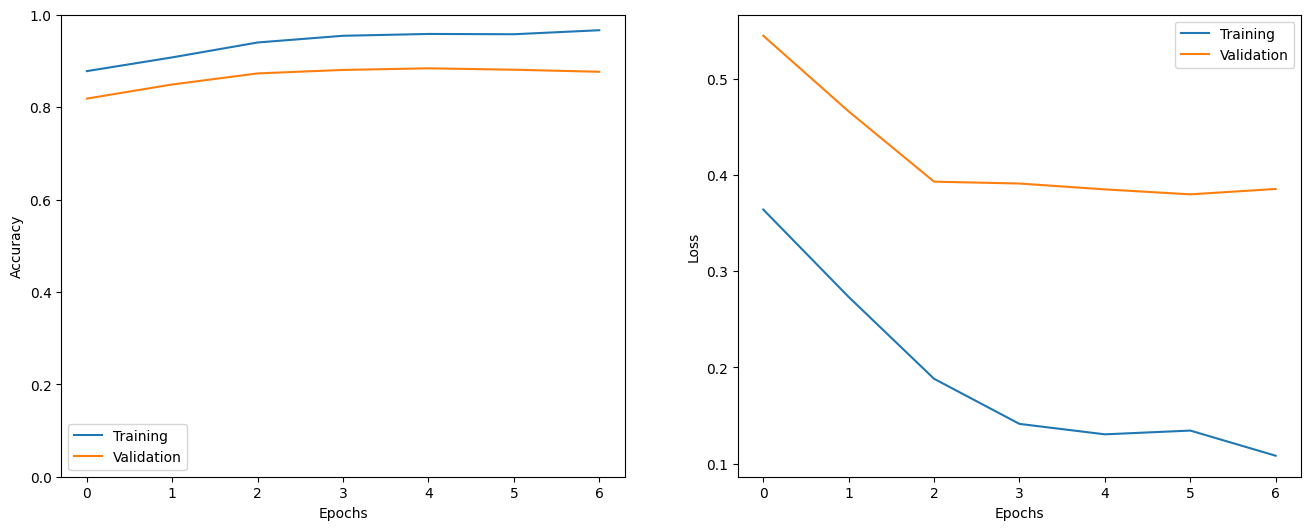

In [51]:
show_history(h)

In [54]:
test_tweets, test_labels = get_tweet(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_tweets = tf.convert_to_tensor(test_sequences)
test_labels = tf.convert_to_tensor(test_labels)

In [55]:
_ = model.evaluate(test_sequences, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8736 - loss: 0.4227


In [66]:
# Access the ith tweet from the test dataset and make a prediction
i = random.randint(0, len(test_labels) - 1)
tweet = test['text'][i]

print('Tweet:', tweet)
print('Emotion:', label_dict[test_labels[i].numpy()])

p = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]
pred_class = np.argmax(p).astype('uint8')

print('Predicted Emotion:', label_dict[pred_class])

Tweet: i feel like a naughty school girl because i am falling behind
Emotion: love
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Emotion: love


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


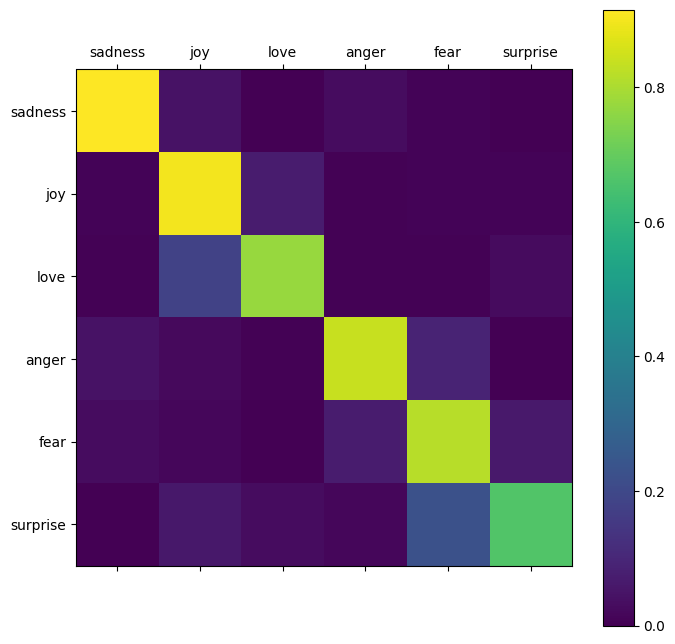

In [67]:
preds = model.predict(test_sequences).argmax(axis=1)
show_confusion_matrix(test_labels, preds, list(label_dict.values()))

the model does a pretty decent job at prediction. the common missclassification is between love and joy